In [1]:
%load_ext autoreload
%autoreload 2

# Grad-CAM Heatmap to Spectrogram Conversion for Waveform-Input Models

Title: **Exploring the Fusion of Visualization and Audio Analysis: Grad-CAM Heatmap to Spectrogram Conversion for Waveform-Input Models**

Introduction:

The advent of deep learning in audio signal processing has revolutionized how we analyze, understand, and manipulate sound. Models that take raw waveforms as input have shown remarkable performance in tasks ranging from speech recognition to music genre classification. However, interpreting these "black box" models remains a challenge. This is where techniques like Gradient-weighted Class Activation Mapping (Grad-CAM) come into play, providing visual explanations for the decisions made by convolutional neural networks (CNNs). 

Grad-CAM generates heatmaps that highlight the regions in the input image that are most relevant for predicting a particular class. While originally designed for image classification tasks, adapting Grad-CAM for waveform-input models introduces a unique challenge: translating the spatial significance of an image to the temporal and frequency dimensions of audio. Here, we propose an innovative approach to convert Grad-CAM heatmaps into spectrograms, which are visual representations of the spectrum of frequencies of a signal as it varies with time. This conversion not only bridges the gap between the visual interpretation tools of image processing and the domain of audio analysis but also provides a novel way to interpret how waveform-input models make their decisions.

**Why Convert Grad-CAM Heatmaps to Spectrograms?**

1. **Enhanced Interpretability:** By converting the heatmaps to spectrograms, we can directly correlate the model's focus areas with the actual audio features, making it easier for audio engineers, researchers, and even musicians to understand what aspects of the sound the model is attending to.

2. **Temporal and Frequency Analysis:** Spectrograms allow us to see how the importance of different frequency components changes over time, which is crucial for understanding dynamic audio signals like music or speech.

3. **Model Debugging and Improvement:** This conversion can help in identifying whether the model is focusing on the right audio features for classification, which can lead to better model design, training, and feature engineering.

4. **Educational and Creative Applications:** The visual representation of what a model 'hears' can be used in educational contexts to teach about audio signal processing or in creative applications where artists can interact with AI in new ways.

In this paper, we will delve into the methodology behind converting Grad-CAM heatmaps to spectrograms, discuss the implications for waveform-input models, and explore potential applications. This work aims to push the boundaries of model interpretability, combining the strengths of visual and auditory analysis to foster a deeper understanding of how deep learning models perceive and process audio data.

## Introduction

This notebook demonstrates:
- how to apply the **Grad-CAM** technique to generate a heatmap for a waveform-input model, and subsequently
- convert the heatmap of the waveform into a spectrogram using Torch.

The notebook guides through the process of installing necessary libraries, importing required libraries and loading a dataset of waveforms, defining a PyTorch model that takes waveforms as input, applying Grad-CAM to generate a heatmap, converting the heatmap into a spectrogram with Torch, and finally visualizing the resulting spectrogram using a library like matplotlib or seaborn.

## Import Libraries and Load Data

In [2]:
# Import necessary libraries
import torch
import torchvision
import numpy as np  # for numerical computations
import matplotlib.pyplot as plt  # for plotting (optional)
from torch.utils.data import DataLoader

In [3]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
from ay2.torch.data.audio import WaveDataset

### Load data

We use Codecfake dataset for testing.

In [5]:
from ay2.datasets.audio import Codecfake_AudioDs
from ay2.datasets.audio._codecfake import ROOT_PATH as Codecfake_Root_path

In [6]:
codecfake = Codecfake_AudioDs(root_path=Codecfake_Root_path)
# We only use the first 5 samples in codecfake.
ds = WaveDataset(data=codecfake.data.iloc[0:5])

/usr/local/ay_data/packages2/ay2/datasets/base.py:78: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data_path)


In [7]:
ds[0]

{'sample_rate': 16000,
 'label': 0,
 'name': '/mnt/data1/zky/Codecfake16k/test/A1/L1_p225_004.wav',
 'vocoder_label': 8,
 'speed_label': 5,
 'compression_label': 0,
 'audio': tensor([[ 0.0005,  0.0004,  0.0003,  ..., -0.0005, -0.0005, -0.0004]])}

Look the first element of the `ds`. As can be seen, the data structure is 
```python
{'sample_rate': audio fps,
 'label': 0 or 1,
 'name':  path of audio,
 'vocoder_label': 8,
 'speed_label': 5,
 'compression_label': 0,
 'audio': torch.Tensor with shape of (1, L)
}
```

## Define Waveform-Input Model

We use the AASIST model that uses 1D waveform as input for presentation.

In [8]:
import sys
sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio")

from models.Aaasist import AASIST_lit

In [9]:
def get_spectrogram(x):
    n_fft = 512
    hop_length = 256
    
    # Compute STFT
    spec_f = torch.stft(
        x,
        n_fft=n_fft,
        hop_length=hop_length,
        return_complex=True,
        center=False
    )
    spec = spec_f.abs().pow(2)
    phase = spec_f.angle()
    return spec, phase

In [10]:
model = AASIST_lit(ckpt_path="/home/ay/data/DATA/1-model_save/00-Deepfake/1-df-audio/AASIST/Codecfake/version_0/checkpoints/best-epoch=1-val-auc=0.9999.ckpt")
class tmpModel(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

    def set_phase_length(self, phase, length):
        self.phase = phase
        self.length = length
    
    def forward(self, spec):
        """
        Args:
            spec: (B, C, H, W) where C = 1
        """
        
        n_fft = 512
        hop_length = 256

        spec = spec[:, 0, :, :]
        
        # Combine magnitude and phase into a complex-valued tensor
        if self.phase.device != spec.device:
            phase = phase.to(spec.device)
        complex_spec_f = torch.polar(spec.sqrt(), self.phase)
        
        # Convert spectrogram back to audio (inverse STFT)
        reconstructed_audio = torch.istft(
            complex_spec_f,
            n_fft=n_fft,
            hop_length=hop_length,
            length=self.length
        )
        # print(reconstructed_audio.shape, x.shape)
        feat, logits = self.model(reconstructed_audio)
        return logits

no. model params:297705


Note that AASIST model's forward method returns both the feature and logits.

In [11]:
model = AASIST_lit(
    ckpt_path="/home/ay/data/DATA/1-model_save/00-Deepfake/1-df-audio/AASIST/Codecfake/version_0/checkpoints/best-epoch=1-val-auc=0.9999.ckpt"
)
model = tmpModel(model.model)
x = torch.randn(1, 48000)
spec, phase = get_spectrogram(x)
model.set_phase_length(phase, 48000)
model(spec[:, None, :, :])

no. model params:297705


/tmp/ipykernel_27899/583951192.py:29: UserWarning: The length of signal is shorter than the length parameter. Result is being padded with zeros in the tail. Please check your center and hop_length settings. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:1167.)
  reconstructed_audio = torch.istft(


tensor([[1.6557]], grad_fn=<AddmmBackward0>)

In [12]:
print(spec.shape, phase.shape)

torch.Size([1, 257, 186]) torch.Size([1, 257, 186])


## Apply Grad-CAM Technique to Generate Heatmap

In [13]:
# Import necessary libraries
from pytorch_grad_cam import GradCAM
import matplotlib.pyplot as plt
import cv2


from ay2.tools.image import read_image

from my_pytorch_grad_cam import GradCAM
from my_pytorch_grad_cam.utils.image import show_cam_on_image
from my_pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import librosa

In [14]:
def get_cam(target_layers, x, target_class=0):
    input_tensor = x
    input_tensor = model.feature_model.preprocess(input_tensor)
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    return grayscale_cam

In [15]:
def plot_cam(spec_path, grayscale_cam):
    
    mask = grayscale_cam
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    spec = read_image(spec_path) / 255
    # spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))
    image_weight = 0.5
    cam = (1 - image_weight) * heatmap + image_weight * spec
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    plt.imshow(cam)
    return cam

In [16]:
x = ds[0]
audio = x['audio'][:, :48000]
label = x['label']
spec, phase = get_spectrogram(audio)

magnitude = np.abs(spec[0])
magnitude_db = librosa.amplitude_to_db(magnitude)
plt.imsave(f"0.jpg", magnitude_db)

In [21]:
target_layers = [model.model.pool_hT2]
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(0)]
model.set_phase_length(phase, 48000)
grayscale_cam = cam(input_tensor=spec[:, None, :, :], targets=targets)[0]
# grayscale_cam = np.transpose(grayscale_cam, (0, 1))

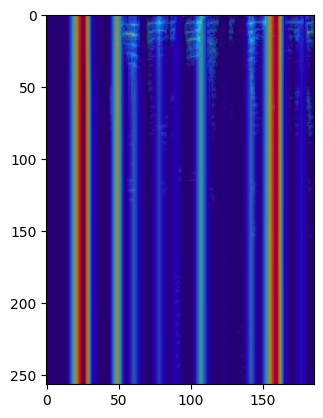

In [22]:
cam = plot_cam(f"0.jpg", grayscale_cam)
plt.imsave(f"1.jpg", cam)